In [1]:
import os, pickle, cPickle, sys, urllib, gzip, sys
sys.setrecursionlimit(10000)

In [2]:
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [20]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print 'Using cuda_convnet (faster)'
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print 'Using lasagne.layers (slower)'

Using cuda_convnet (faster)


In [5]:
fname = 'mnist/mnist.pkl.gz'
if not os.path.isfile(fname):
    testfile = urllib.URLopener()
    testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
f = gzip.open(fname, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
X, y = train_set
X = np.rint(X * 256).astype(np.int).reshape((-1, 1, 28,28)) # convert to (0,255) int range (we'll do our own scaling)
mu, sigma = np.mean(X.flatten()), np.std(X.flatten())

In [6]:
X_train = X.astype(np.float64)
X_train = (X_train - mu) / sigma
X_train = X_train.astype(np.float32)

# we need our target to be 1 dimensional
X_out = X_train.reshape((X_train.shape[0], -1))

In [38]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
deconv_filters = 32
epochs = 20
encode_size = 16
dense_mid_size = 128
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 800}),
    (ReshapeLayer, {'shape': (([0], 32, 5, 5))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': 'full'}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': 16, 'filter_size': filter_size, 'pad': 'full'}),
    (Conv2DLayerSlow, {'num_filters': 1, 'filter_size': filter_size, 'pad': 'full'}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [52]:
ae = NeuralNet(
    layers=layers,
    max_epochs=epochs,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [53]:
ae.fit(X_train, X_out)

# Neural Network with 224177 learnable parameters

## Layer information

  #  name          size
---  ------------  --------
  0  input0        1x28x28
  1  conv2dcc1     16x26x26
  2  conv2dcc2     16x24x24
  3  maxpool2dcc3  16x12x12
  4  conv2dcc4     32x10x10
  5  maxpool2dcc5  32x5x5
  6  reshape6      800
  7  dense7        128
  8  encode        16
  9  dense9        128
 10  dense10       800
 11  reshape11     32x5x5
 12  upscale2d12   32x10x10
 13  conv2dcc13    16x12x12
 14  upscale2d14   16x24x24
 15  conv2d15      16x26x26
 16  conv2d16      1x28x28
 17  reshape17     784

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.64647       0.49946      1.29434  6.36s
      2       0.45208       0.42124      1.07321  6.35s
      3       0.39637       0.37252      1.06403  6.29s
      4       0.36445       0.35297      1.03253  6.37s
      5       0.34905       0.34216      1.02014  6.28s
      6       0.3

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f843459a950>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f843459a8d0>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 28, 28)}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'num_filters': 16}), (<class 'lasagne.layers.cuda_convnet.Conv2DCCLayer'>, {'filter_size': 3, 'num_filters': 16}), (<class 'lasagne.layers.cuda_...d': 'full', 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f843459f578>,
     objective_loss_function=<function squared_error at 0x7f8435ffec08>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f83e7305320>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInf

In [54]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('mnist/conv_ae.pkl','w'))
# ae = pickle.load(open('mnist/conv_ae.pkl','r'))
# ae.layers

In [55]:
X_train_pred = ae.predict(X_train).reshape(-1, 28, 28) * sigma + mu
X_pred = np.rint(X_train_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')
print X_pred.shape , X.shape

(50000, 28, 28) (50000, 1, 28, 28)


In [56]:
!mkdir -p data
!mkdir -p montage

1000


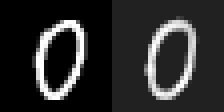

In [57]:
###  show random inputs / outputs side by side

def get_picture_array(X, index, rescale=4):
    array = X[index].reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def get_random_images():
    index = np.random.randint(5000)
    print index
    original_image = Image.fromarray(get_picture_array(X, index))
    new_size = (original_image.size[0] * 2, original_image.size[1])
    new_im = Image.new('L', new_size)
    new_im.paste(original_image, (0,0))
    rec_image = Image.fromarray(get_picture_array(X_pred, index))
    new_im.paste(rec_image, (original_image.size[0],0))
    new_im.save('data/test.png', format="PNG")    

get_random_images()
IPImage('data/test.png')

In [58]:
## we find the encode layer from our ae, and use it to define an encoding function

def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None
encode_layer, encode_layer_index = get_layer_by_name(ae, 'encode')

def get_output_from_nn(last_layer, X, batch_size=128):
    indices = np.arange(batch_size, X.shape[0], batch_size)
    X_batches = np.split(X, indices)
    out = []
    for X_batch in X_batches:
        out.append(get_output(last_layer, inputs=X_batch).eval())
    return np.vstack(out)

def encode_input(X):
    return get_output_from_nn(encode_layer, X)

X_encoded = encode_input(X_train)

In [59]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

(1, 784)


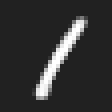

In [60]:
def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

X_decoded = decode_encoded_input(X_encoded[3]) * sigma + mu

X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print X_decoded.shape

pic_array = get_picture_array(X_decoded, np.random.randint(len(X_decoded)))
image = Image.fromarray(pic_array)
image.save('data/test.png', format="PNG")  
IPImage('data/test.png')

In [61]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [62]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * sigma + mu
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded, i, rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

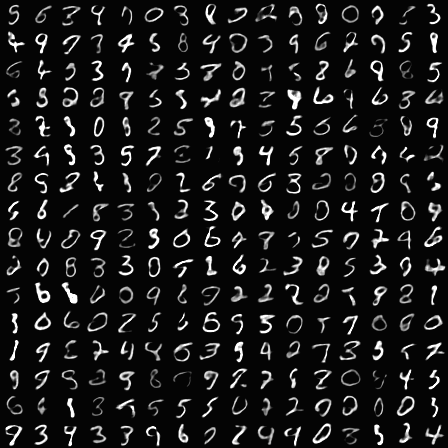

In [63]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')